### Dummy Train to Overfit

In [1]:
from utility.utils import *
from dataset.dataset import *
from dataset.transform import *
from model.loss import *
from model.unet import UNet256_3x3
from training.classifier import NucleiClassifier

import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2

In [2]:
train_path = '../data/ds_bowl_2018/sub_data/train/'
valid_path = '../data/ds_bowl_2018/sub_data/valid/'

1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88.png


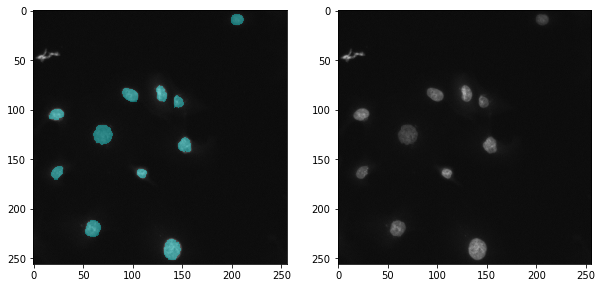

1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5.png


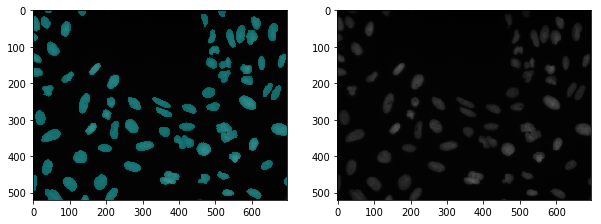

1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b.png


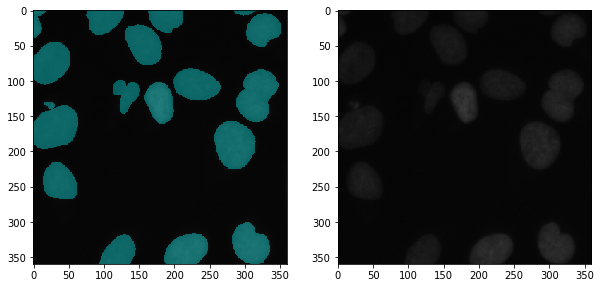

In [3]:
# Look at training images
image_mask_paths = get_image_onemask_paths(train_path)
for img_path , mask_path in image_mask_paths:
    show_image(img_path, mask_path, figsize=(10, 10))

1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b.png


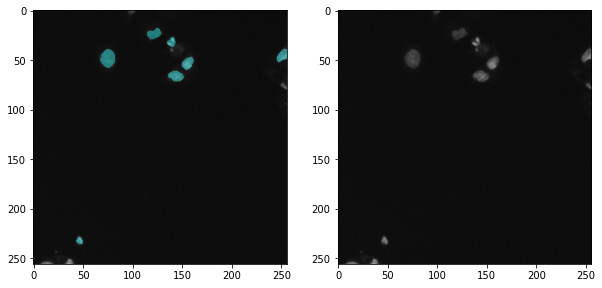

In [4]:
# Look at validation images
image_mask_paths = get_image_onemask_paths(valid_path)
for img_path , mask_path in image_mask_paths:
    show_image(img_path, mask_path, figsize=(10, 10))

### Training

In [5]:
def augment(image, mask, index, sz = 256):
    image, mask = fix_resize_transform2(image, mask, sz, sz)
    image = (image.transpose((2,0,1))) / 255 #normalize, batchnorm will be better for future
    mask = mask[None, :] / 255 # make 0 and 1
    return image.astype(np.float64), mask.astype(np.float64), index

In [6]:
# training
trn_ds = NucleiDataset(train_path, transform=augment, mode='train')
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True)
# validation
val_ds = NucleiDataset(valid_path, transform=augment, mode='valid')
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False)

In [7]:
# training definition
net = UNet256_3x3((3, 256, 256), 1).double()
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters())
bce_loss2d = BCELoss2d()

In [8]:
classifier = NucleiClassifier(net, 100)

In [18]:
classifier.train(trn_dl, val_dl, optimizer, 10)

Epoch: 21
Training : [0.1947 , 0.8911],Validation : [0.8118 , 0.3658]
Epoch: 22
Training : [0.2173 , 0.8795],Validation : [0.345 , 0.7072]
Epoch: 23
Training : [0.1688 , 0.9045],Validation : [0.4621 , 0.6035]
Epoch: 24
Training : [0.1474 , 0.9193],Validation : [0.3874 , 0.668]
Epoch: 25
Training : [0.1673 , 0.9073],Validation : [0.4473 , 0.6182]
Epoch: 26
Training : [0.1705 , 0.9081],Validation : [0.3792 , 0.6729]
Epoch: 27
Training : [0.1656 , 0.9108],Validation : [0.6381 , 0.5769]
Epoch: 28
Training : [0.1621 , 0.9117],Validation : [0.5185 , 0.5656]
Epoch: 29
Training : [0.1549 , 0.9102],Validation : [0.4821 , 0.6322]
Epoch: 30
Training : [0.1394 , 0.9252],Validation : [0.7034 , 0.605]


In [15]:
def show_predictions(dataloader, classifier, threshold=0.5):
    print('\t\t Image \t\t\t\t\t Mask \t\t\t\t Predicted Mask')
    for img, msk, _ in iter(dataloader):
        plt.figure(figsize=(20, 20))
        out = classifier.net(V(img))
        plt.subplot(1,3,1)
        plt.imshow(img.numpy()[0].transpose(1,2,0))
        plt.subplot(1,3,2)
        plt.imshow(msk.numpy()[0, 0])
        plt.subplot(1,3,3)
        plt.imshow((F.sigmoid(out).data.numpy()[0, 0] > threshold)*1)

		 Image 					 Mask 				 Predicted Mask


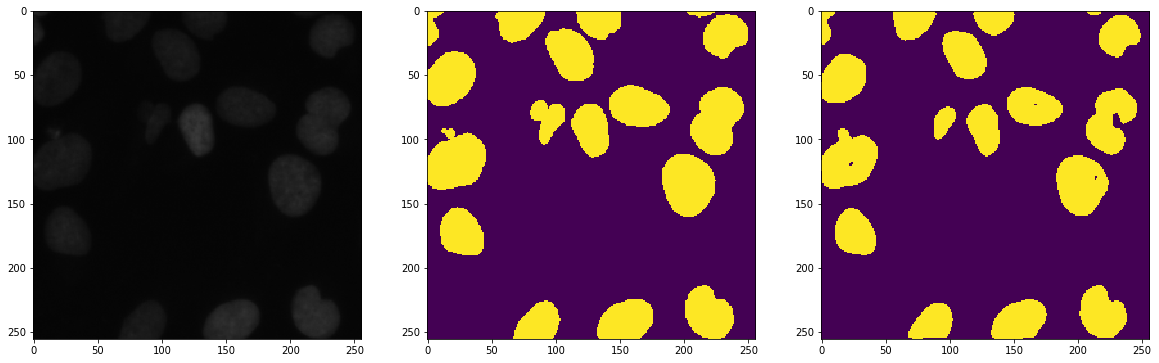

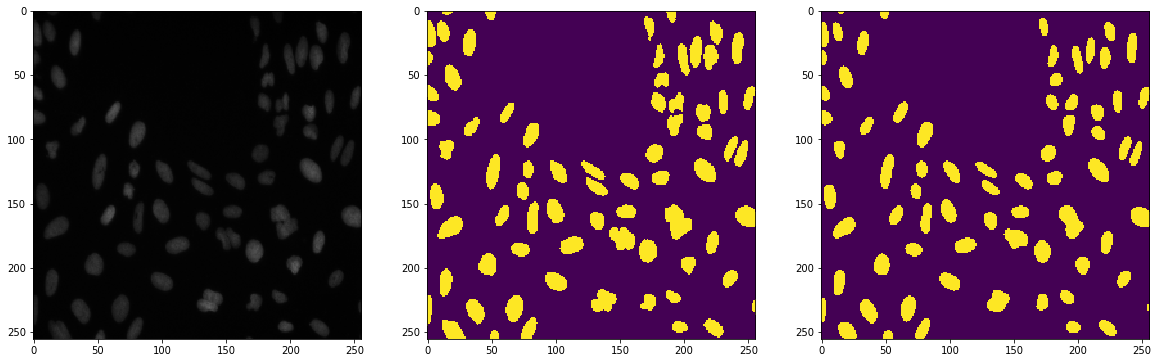

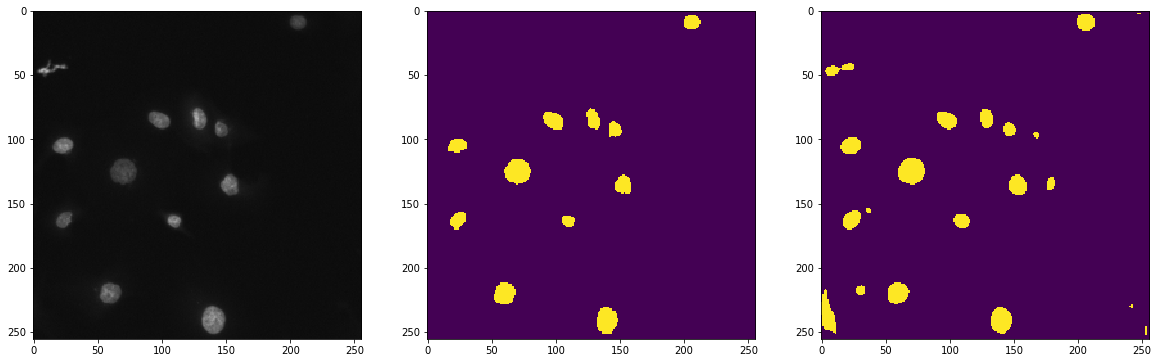

In [16]:
show_predictions(trn_dl, classifier)

		 Image 					 Mask 				 Predicted Mask


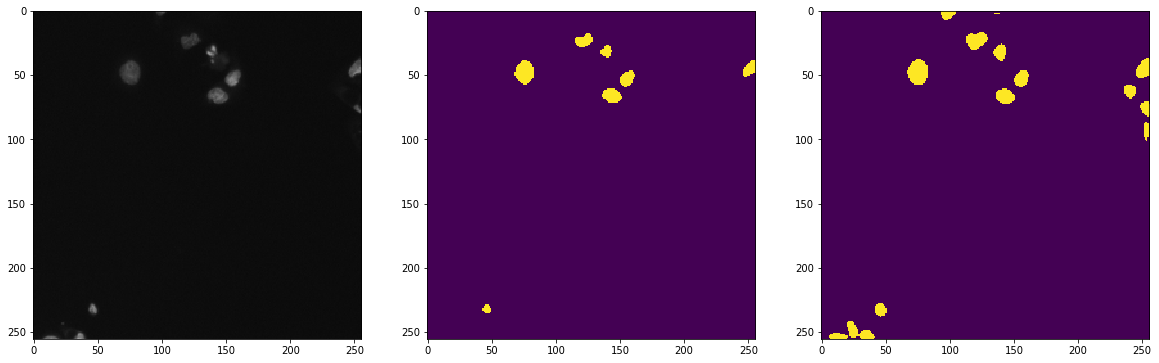

In [17]:
show_predictions(val_dl,classifier)